# This file for build two models U-net and Resnet

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import random
import os

In [ ]:
img_size = (224, 224)
batch_size = 32

In [ ]:
# Define paths
train_dir = "./processed_dataset/train"  
categories = ["Alternaria_solani", "Healthy", "Insect", "Phytophthora_infestans", "Virus"]

# Data Augmentation Settings
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

num_augmented_images = 5  

# Loop through each category and apply augmentation
for category in categories:
    class_dir = os.path.join(train_dir, category)  
    save_dir = class_dir  

    os.makedirs(save_dir, exist_ok=True)
    images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    for image_name in images:
        image_path = os.path.join(class_dir, image_name)
        img = load_img(image_path)  
        img_array = img_to_array(img)  
        img_array = np.expand_dims(img_array, axis=0)  

        # Generate and save augmented images
        aug_iter = datagen.flow(img_array, batch_size=1, save_to_dir=save_dir, 
                                save_prefix="aug", save_format="jpg")

        for _ in range(num_augmented_images):
            next(aug_iter)  

print("✅ Data augmentation completed successfully!")

✅ Data augmentation completed successfully!


In [ ]:
# Define paths
train_dir = "processed_dataset/train"  
val_dir = "processed_dataset/validation"  
test_dir = "processed_dataset/test"  

datagen = ImageDataGenerator(rescale=1./255)

# Load Training Data
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load Validation Data
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load Test Data (No Shuffling)
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)

Found 8794 images belonging to 5 classes.
Found 1559 images belonging to 5 classes.
Found 1110 images belonging to 5 classes.


In [11]:
print(train_generator.class_indices)

{'Alternaria_solani': 0, 'Healthy': 1, 'Insect': 2, 'Phytophthora_infestans': 3, 'Virus': 4}


In [ ]:
for category in categories:
    print(f"{category}: {len(os.listdir(os.path.join(train_dir, category)))} images")

Alternaria_solani: 1751 images
Healthy: 1456 images
Insect: 1082 images
Phytophthora_infestans: 1671 images
Virus: 2838 images


### display sample images from each class

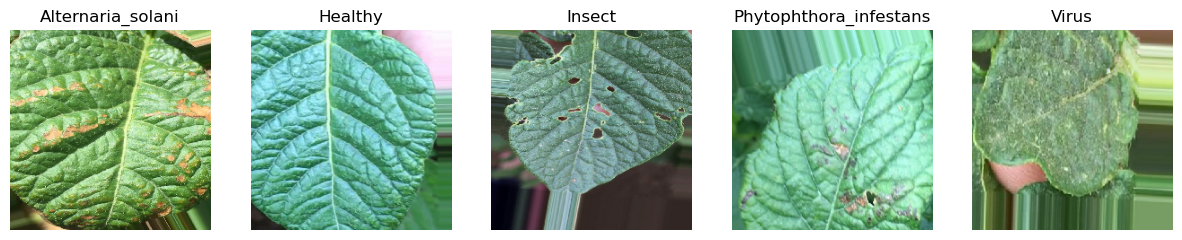

In [ ]:
class_dir = "./processed_dataset/train"
fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))
for i, category in enumerate(categories):
    class_dir = os.path.join(train_dir, category)
    img_name = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_name)
    img = image.load_img(img_path, target_size=(224, 224))
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(category)
plt.show()

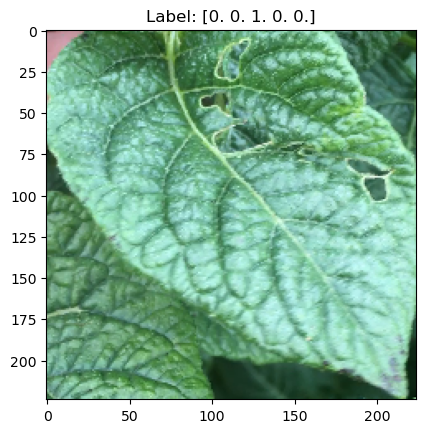

In [ ]:
x, y = next(train_generator)
plt.imshow(x[0])
plt.title(f"Label: {y[0]}")
plt.show()

## Build DeepLearning ResNet model

In [ ]:
# Load ResNet50 with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze last layers for fine-tuning
for layer in base_model.layers[:100]:  
    layer.trainable = False
for layer in base_model.layers[100:]:  
    layer.trainable = True

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)  

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,213,253 (100.00 MB)

 Trainable params: 22,078,469 (84.22 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

In [ ]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50, 
    batch_size=batch_size,  
    callbacks=[reduce_lr, early_stopping, checkpoint],
)

Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.3399 - loss: 1.7319Epoch 1/50
 - loss: 1.5097 - accuracy: 0.4133 - val_loss: 0.7812 - val_accuracy: 0.7161
220/220 ━━━━━━━━━━━━━━━━━━━━ 208s 924ms/step - accuracy: 0.3403 - loss: 1.7309 - val_accuracy: 0.7161 - val_loss: 0.7812
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.5346 - loss: 1.1623Epoch 2/50
 - loss: 1.1132 - accuracy: 0.5554 - val_loss: 0.6636 - val_accuracy: 0.7323
220/220 ━━━━━━━━━━━━━━━━━━━━ 205s 931ms/step - accuracy: 0.5347 - loss: 1.1621 - val_accuracy: 0.7323 - val_loss: 0.6636
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - accuracy: 0.6142 - loss: 0.9889Epoch 3/50
 - loss: 0.9386 - accuracy: 0.6408 - val_loss: 0.6289 - val_accuracy: 0.7742
220/220 ━━━━━━━━━━━━━━━━━━━━ 207s 942ms/step - accuracy: 0.6143 - loss: 0.9887 - val_accuracy: 0.7742 - val_loss: 0.6289
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.6764 - loss: 0.8634Epoch 4/50
 - loss: 0.842

In [ ]:
model.save("potato_leaf_model1.keras")  

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt 
import seaborn as sns

35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 822ms/step
                        precision    recall  f1-score   support

     Alternaria_solani       0.40      0.40      0.40       420
               Healthy       0.26      0.33      0.29       256
                Insect       0.05      0.04      0.04        47
Phytophthora_infestans       0.21      0.19      0.20       235
                 Virus       0.09      0.06      0.07       152

              accuracy                           0.28      1110
             macro avg       0.20      0.20      0.20      1110
          weighted avg       0.27      0.28      0.27      1110



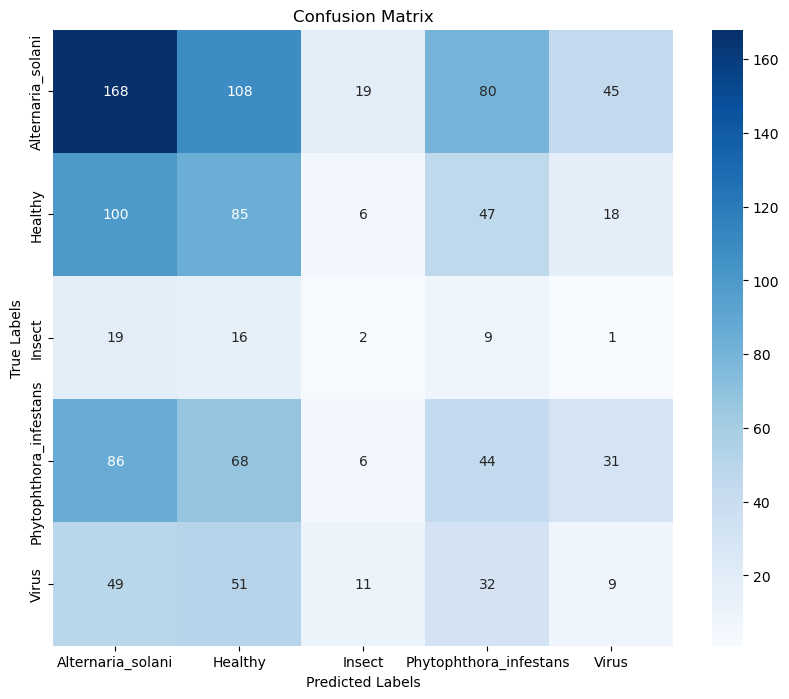

In [ ]:
model = load_model("potato_leaf_model1.keras")
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

# Confusion matrix with proper labels
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ---------------------------------------------------------------------
# Fine tuning while the model accuracy it not good even the val_accuracy
# ---------------------------------------------------------------------

### first try  #1

In [ ]:
# Load the trained model
model = load_model("potato_leaf_model1.keras")
optimizer = Adam(learning_rate=5e-5)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("potato_disease_best1.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

# Recompile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    epochs=10,  
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

# Save the final model
model.save("potato_disease_final.keras")

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9447 - loss: 0.1747
Epoch 1: val_loss improved from inf to 0.81306, saving model to potato_disease_best.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 728s 10s/step - accuracy: 0.9448 - loss: 0.1744 - val_accuracy: 0.7794 - val_loss: 0.8131 - learning_rate: 5.0000e-05
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9663 - loss: 0.1041
Epoch 2: val_loss improved from 0.81306 to 0.63718, saving model to potato_disease_best.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 706s 10s/step - accuracy: 0.9663 - loss: 0.1041 - val_accuracy: 0.8153 - val_loss: 0.6372 - learning_rate: 5.0000e-05
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9651 - loss: 0.1061
Epoch 3: val_loss did not improve from 0.63718
69/69 ━━━━━━━━━━━━━━━━━━━━ 716s 10s/step - accuracy: 0.9652 - loss: 0.1060 - val_accuracy: 0.8196 - val_loss: 0.6636 - learning_rate: 5.0000e-05
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9704 - loss: 0.0877

### Second try #2

In [ ]:
model = load_model("potato_disease_best1.keras")

optimizer = Adam(learning_rate=5e-5)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("potato_disease_best2.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

# Recompile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_finetune = model.fit(
    train_generator,
    epochs=10,  
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

# Save the final model
model.save("potato_disease_final3.keras")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9396 - loss: 0.1739
Epoch 1: val_loss improved from inf to 0.21327, saving model to potato_disease_best2.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 1705s 10s/step - accuracy: 0.9396 - loss: 0.1738 - val_accuracy: 0.9357 - val_loss: 0.2133 - learning_rate: 5.0000e-05
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9538 - loss: 0.1367
Epoch 2: val_loss improved from 0.21327 to 0.18487, saving model to potato_disease_best2.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 1704s 10s/step - accuracy: 0.9539 - loss: 0.1367 - val_accuracy: 0.9395 - val_loss: 0.1849 - learning_rate: 5.0000e-05
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9658 - loss: 0.1028
Epoch 3: val_loss did not improve from 0.18487
177/177 ━━━━━━━━━━━━━━━━━━━━ 1750s 10s/step - accuracy: 0.9658 - loss: 0.1028 - val_accuracy: 0.9382 - val_loss: 0.1892 - learning_rate: 5.0000e-05
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.97

In [ ]:
model = load_model("potato_disease_final3.keras") 
test_steps = test_generator.samples // batch_size
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9734 - loss: 0.0912
Test Accuracy: 95.68%


18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step
                        precision    recall  f1-score   support

     Alternaria_solani       1.00      1.00      1.00       420
               Healthy       0.95      0.91      0.93       256
                Insect       0.95      0.83      0.89        47
Phytophthora_infestans       0.99      0.98      0.99       235
                 Virus       0.83      0.93      0.88       152

              accuracy                           0.96      1110
             macro avg       0.94      0.93      0.93      1110
          weighted avg       0.96      0.96      0.96      1110



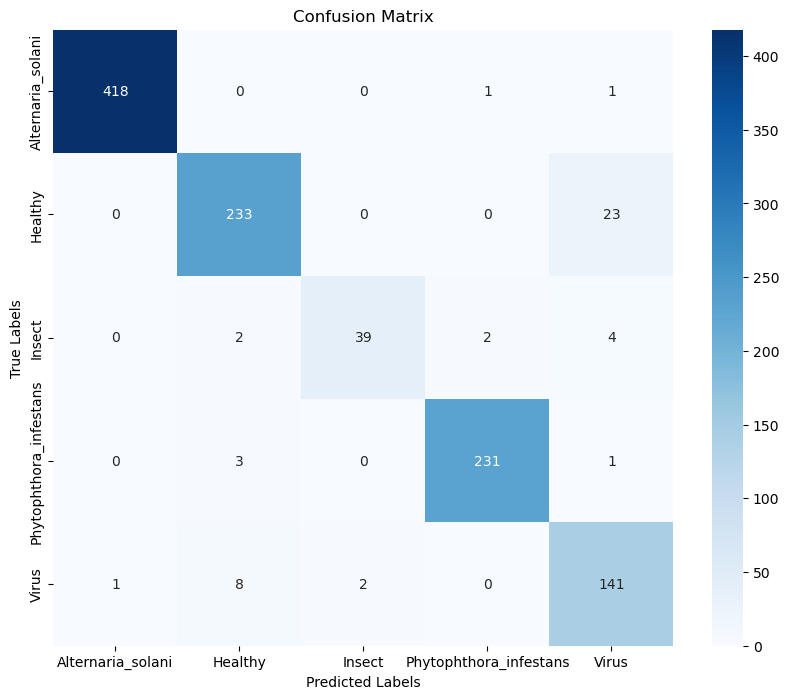

In [ ]:
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

# Confusion matrix with proper labels
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Third try #3

In [ ]:
base_model = load_model("potato_disease_final3.keras")

# Rebuild the model with Dropout & L2 Regularization
inputs = base_model.input
x = base_model.layers[-2].output  
x = Dropout(0.4)(x)  
x = Dense(5, activation="softmax", kernel_regularizer=l2(0.001))(x)  # Recreate final layer with L2 Regularization

model = Model(inputs, x)

def lr_scheduler(epoch, lr):
    return 1e-4 * (0.95 ** epoch)  # Reduce LR by 5% every epoch

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("potato_disease_best3.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

optimizer = Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_finetune = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping, checkpoint, lr_callback]
)

# Save the final model
model.save("potato_disease_final4.keras")



Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6195 - loss: 1.1092
Epoch 1: val_loss improved from inf to 0.22496, saving model to potato_disease_best3.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 1647s 9s/step - accuracy: 0.6206 - loss: 1.1063 - val_accuracy: 0.9319 - val_loss: 0.2250 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.5e-05.
Epoch 2/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9532 - loss: 0.1639
Epoch 2: val_loss did not improve from 0.22496
177/177 ━━━━━━━━━━━━━━━━━━━━ 1674s 9s/step - accuracy: 0.9532 - loss: 0.1638 - val_accuracy: 0.9369 - val_loss: 0.2551 - learning_rate: 9.5000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.025e-05.
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9712 - loss: 0.1033
Epoch 3: val_loss did not improve from 0.22496
177/177 ━━━━━━━━━━━━━━━━━━━━ 1667s 9s/step - accuracy: 0.9713 - loss: 

In [ ]:
model = load_model("potato_disease_final4.keras") 
test_steps = test_generator.samples // batch_size
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9683 - loss: 0.1089
Test Accuracy: 95.59%


18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step
                        precision    recall  f1-score   support

     Alternaria_solani       1.00      0.98      0.99       420
               Healthy       0.93      0.92      0.93       256
                Insect       0.95      0.85      0.90        47
Phytophthora_infestans       0.97      0.99      0.98       235
                 Virus       0.85      0.92      0.89       152

              accuracy                           0.95      1110
             macro avg       0.94      0.93      0.94      1110
          weighted avg       0.96      0.95      0.96      1110



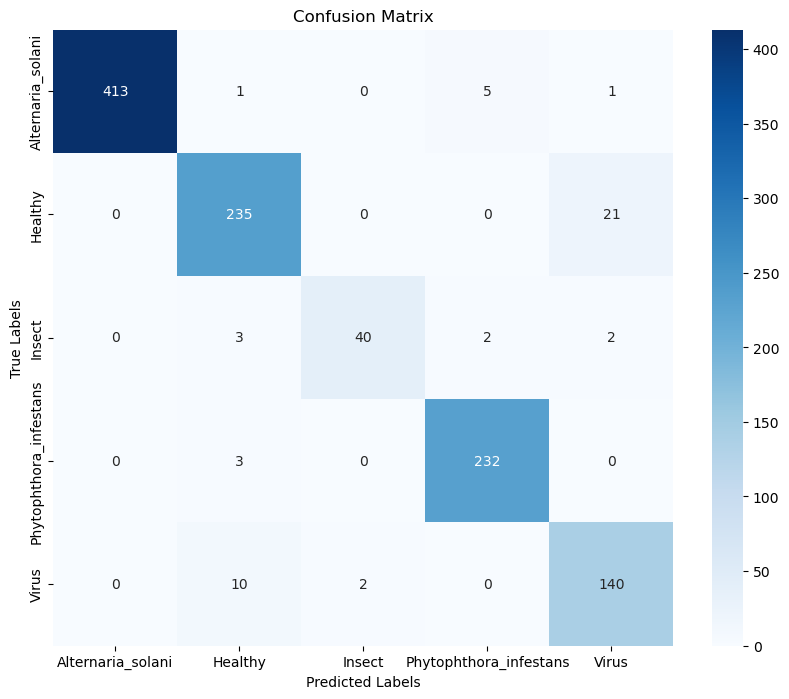

In [ ]:
# Generate predictions for the test set
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

# Confusion matrix with proper labels
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ---------------------------------------------------------------------
# Generates Grad-CAM heatmap to highlight points that model focus on
# ---------------------------------------------------------------------

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
conv_outputs shape: (1, 14, 14, 1024)
grads shape (after fix): (1, 14, 14, 1024)


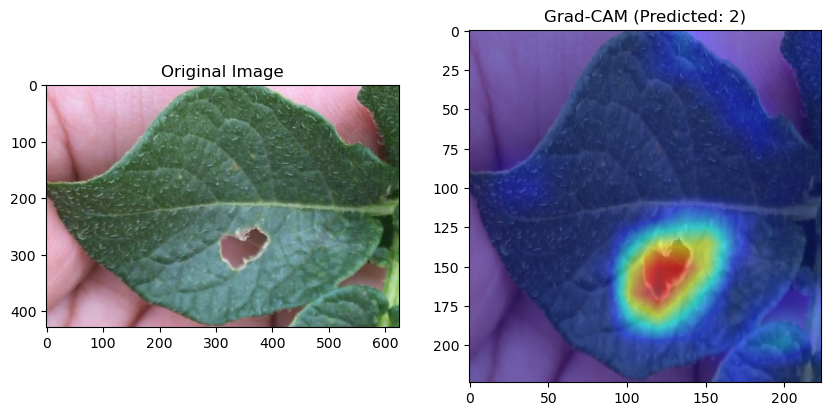

In [ ]:
model = tf.keras.models.load_model("potato_disease_final4.keras")

def get_gradcam(img_path, model, layer_name):    
    # Load & preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0 
    
    # Get model predictions
    preds = model.predict(img_array)
    class_idx = np.argmax(preds[0])  

    # Get the output of the desired convolutional layer
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]  
        
    grads = tape.gradient(loss, conv_outputs)

    if grads is None:
        raise ValueError("Gradients are None! Check layer name and model structure.")

    # Ensure batch dimension
    if len(grads.shape) == 3:  
        grads = tf.expand_dims(grads, axis=0)  

    # Check shapes
    print("conv_outputs shape:", conv_outputs.shape)
    print("grads shape (after fix):", grads.shape)  

    # Compute pooled gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply feature maps by pooled gradients
    conv_outputs = conv_outputs[0].numpy()
    for i in range(pooled_grads.shape[0]):  
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    
    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap, class_idx


def overlay_heatmap(img_path, heatmap, alpha=0.5):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    
    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (224, 224))

    # Apply Gaussian blur for better visualization
    heatmap = cv2.GaussianBlur(heatmap, (5, 5), 0)

    heatmap = np.uint8(255 * heatmap)  
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay heatmap onto image
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    
    return superimposed_img

test_img_path = "./processed_dataset/test/Insect/Insect209.png"

# Generate Grad-CAM
heatmap, predicted_class = get_gradcam(test_img_path, model, layer_name="conv4_block6_out")  

# Overlay heatmap
superimposed_img = overlay_heatmap(test_img_path, heatmap)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM (Predicted: {predicted_class})")

plt.show()